In [78]:
## Set Python - Spark environment.
import os
import sys
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.6-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import isnan, when, count, col, countDistinct
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql.functions import isnan, when, count, col, countDistinct
from pyspark.ml.feature import OneHotEncoder, StringIndexer
import seaborn as sns

In [3]:
## Create SparkContext, SparkSession
from os.path import expanduser, join, abspath

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row

# warehouse_location points to the default location for managed databases and tables
warehouse_location = 'hdfs:///apps/hive/warehouse/'

spark = SparkSession \
    .builder \
    .appName("Python_Spark_PHD_Complete") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

sc = spark.sparkContext

In [4]:
spark

In [ ]:
### Insert the sqoop command in the below cells

In [ ]:
# sqoop job \
# --create initialimport_2334 \
# -- import-all-tables \
# --connect jdbc:mysql://172.16.0.228:3306/insofe_b48_energyDB \
# --username insofeadmin \
# --password insofe_password \
# --warehouse-dir '/user/2334B48/Phd/' \
# -m 1

In [ ]:
# sqoop job --exec initialimport_2334

### We have to supply two different schema becuase test data doesnt have 'Appliance' column. Note that we also cant check the performance of different models on the test data

In [122]:
traindataSchema = StructType([
    StructField("billdate", StringType(), True),
    StructField("Appliances", IntegerType(), True),
    StructField("lights", IntegerType(), True),
    StructField("T1", DoubleType(), True),
    StructField("RH_1", DoubleType(), True),
    StructField("T2", DoubleType(), True),
    StructField("RH_2", DoubleType(), True),
    StructField("T3", DoubleType(), True),
    StructField("RH_3", DoubleType(), True),
    StructField("T4", DoubleType(), True),
    StructField("RH_4", DoubleType(), True),
    StructField("T5", DoubleType(), True),
    StructField("RH_5", DoubleType(), True),
    StructField("T6", DoubleType(), True),
    StructField("RH_6", DoubleType(), True),
    StructField("T7", DoubleType(), True),
    StructField("RH_7", DoubleType(), True),
    StructField("T8", DoubleType(), True),
    StructField("RH_8", DoubleType(), True),
    StructField("T9", DoubleType(), True),
    StructField("RH_9", DoubleType(), True),
    StructField("To", DoubleType(), True),
    StructField("mm_hg", DoubleType(), True),
    StructField("RH_out", DoubleType(), True),
    StructField("Wind_speed", DoubleType(), True),
    StructField("Visibility", DoubleType(), True),
    StructField("Tdewpoint", DoubleType(), True),
    StructField("rv1", DoubleType(), True),
    StructField("rv2", DoubleType(), True),
    StructField("nsm", IntegerType(), True),
    StructField("Weekstatus", StringType(), True),
    StructField("Day_of_week", StringType(), True)])

testdataSchema = StructType([
    StructField("billdate", StringType(), True),
    StructField("lights", IntegerType(), True),
    StructField("T1", DoubleType(), True),
    StructField("RH_1", DoubleType(), True),
    StructField("T2", DoubleType(), True),
    StructField("RH_2", DoubleType(), True),
    StructField("T3", DoubleType(), True),
    StructField("RH_3", DoubleType(), True),
    StructField("T4", DoubleType(), True),
    StructField("RH_4", DoubleType(), True),
    StructField("T5", DoubleType(), True),
    StructField("RH_5", DoubleType(), True),
    StructField("T6", DoubleType(), True),
    StructField("RH_6", DoubleType(), True),
    StructField("T7", DoubleType(), True),
    StructField("RH_7", DoubleType(), True),
    StructField("T8", DoubleType(), True),
    StructField("RH_8", DoubleType(), True),
    StructField("T9", DoubleType(), True),
    StructField("RH_9", DoubleType(), True),
    StructField("To", DoubleType(), True),
    StructField("mm_hg", DoubleType(), True),
    StructField("RH_out", DoubleType(), True),
    StructField("Wind_speed", DoubleType(), True),
    StructField("Visibility", DoubleType(), True),
    StructField("Tdewpoint", DoubleType(), True),
    StructField("rv1", StringType(), True),
    StructField("rv2", StringType(), True),
    StructField("nsm", IntegerType(), True),
    StructField("Weekstatus", StringType(), True),
    StructField("Day_of_week", StringType(), True)])

traindata1 = spark.read.format("csv")\
       .option("header", "false")\
       .option("inferSchema", "true")\
       .load("hdfs:///user/2334B48/Phd/energy_traindb_data/part-m-00000", schema = traindataSchema)
testdata1 = spark.read.format("csv")\
       .option("header", "false")\
       .option("inferSchema", "true")\
       .load("hdfs:///user/2334B48/Phd/energy_testdb_data/part-m-00000", schema = testdataSchema)

## Checking for nulls

In [203]:
traindata1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindata1.columns]).show()

+----------+------+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+-----+------+----------+----------+---------+---+----------+-----------+
|Appliances|lights| T1|RH_1| T2|RH_2| T3|RH_3| T4|RH_4| T5|RH_5| T6|RH_6| T7|RH_7| T8|RH_8| T9|RH_9| To|mm_hg|RH_out|Wind_speed|Visibility|Tdewpoint|nsm|Weekstatus|Day_of_week|
+----------+------+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+-----+------+----------+----------+---------+---+----------+-----------+
|         0|     0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|    0|     0|         0|         0|        0|  0|         0|          0|
+----------+------+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+-----+------+----------+----------+---------+---+----------+-----------+



### we see that there are no null values in the train data

- Also, test data had the timestamp missing but we are not using it for prediction

### Exploratory analysis

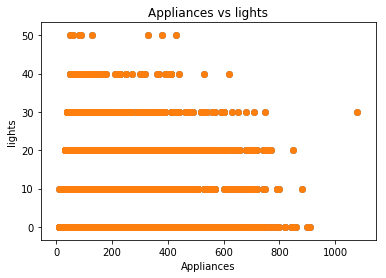

In [147]:
traindata_DF = traindata1.toPandas()

plt.scatter(traindata_DF.Appliances, traindata_DF.lights)
X = traindata_DF.Appliances
Y = traindata_DF.lights
plt.xlabel("Appliances")
plt.ylabel("lights")
plt.title("Appliances vs lights")
plt.scatter(X,Y)
plt.show()

- we notice that although light consumption is a continous variable, we see an increase in steps of 10 and Appliances is varying 
  throughout the range for each value of light

{'boxes': [<matplotlib.lines.Line2D at 0x7b96450>],
 'caps': [<matplotlib.lines.Line2D at 0x7bad1d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x530a450>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x530a810>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ef4190>,
  <matplotlib.lines.Line2D at 0x7badb90>]}

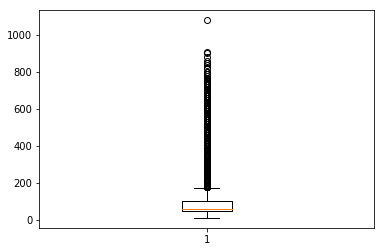

In [126]:
plt.boxplot(traindata_DF.Appliances)

### Based on the boxplot, it looks like there are a lot of outliers in the data but this is because of a lot of 0s in the data (you can see that the red line (mean) is close to 0)

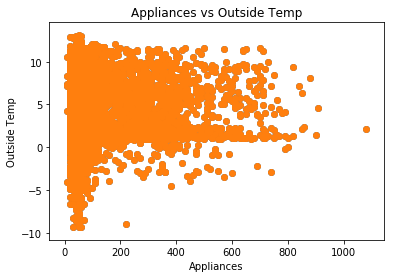

In [127]:
plt.scatter(traindata_DF.Appliances, traindata_DF.To)
X = traindata_DF.Appliances
Y = traindata_DF.To
plt.xlabel("Appliances")
plt.ylabel("Outside Temp")
plt.title("Appliances vs Outside Temp")
plt.scatter(X,Y)
plt.show()

- Very few records exist with outside temperature below -5 degrees
- Between -5 and 10 degrees, we see that the usage is spread all over although with higher density below 400 units
- This indicates very little correlation between outside temperature and overall appliances usage

### Model Building - Regression 

- The random variables are dropped in both train and test data sets as they would lead to learning random patterns in the data
- Given that we have both weekstatus and Day_of_week, billdate is dropped as it is giving partial information
    - Granted that we could deduce time of day and other metrics from date, we will be holding them off given the time       constraints

In [148]:
traindata1 = traindata1.drop('billdate')
traindata1 = traindata1.drop('rv1')
traindata1 = traindata1.drop('rv2')

testdata1 = testdata1.drop('billdate')
testdata1 = testdata1.drop('rv1')
testdata1 = testdata1.drop('rv2')

cat_Var_Names = ['Weekstatus', 'Day_of_week']

num_Var_Names = ['lights', 'T1', 'RH_1', 'T2', 'RH_2','T3', 'RH_3', 'T4', 'RH_4','T5', 'RH_5', 'T6', 'RH_6',
                 'T7', 'RH_7', 'T8', 'RH_8','T9', 'RH_9', 'To', 'mm_hg','RH_out', 'Wind_speed', 'Visibility', 'Tdewpoint', 'nsm']

In [149]:
(trainingData, valData) = traindata1.randomSplit([0.7, 0.3])

In [150]:
from pyspark.ml.feature import VectorAssembler

assembler_Num = VectorAssembler(inputCols=num_Var_Names, outputCol="num_features")



In [151]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

indexers_Cat = [StringIndexer(inputCol=cat_Var_Name, outputCol="{0}_index".format(cat_Var_Name)) for cat_Var_Name in cat_Var_Names ]
encoders_Cat = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_vec".format(indexer.getInputCol())) for indexer in indexers_Cat]
assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders_Cat], outputCol="cat_features")

assembler = VectorAssembler(inputCols=["scaled_num_features","cat_features"], outputCol="features")
preprocessiong_Stages = [assembler_Num]+[min_Max_Scalar]+indexers_Cat+encoders_Cat+[assembler_Cat]+[assembler]

In [152]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=100,labelCol="Appliances", featuresCol="features")

from pyspark.ml import Pipeline
lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr]) 
lr_Pipeline_model = lr_Pipeline.fit(trainingData)
train_predictions_lr = lr_Pipeline_model.transform(trainingData)
val_predictions_lr = lr_Pipeline_model.transform(valData)

In [153]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Appliances",
                            predictionCol="prediction",
                            metricName="rmse" )
lmRegTrain_rmse = evaluator.evaluate(train_predictions_lr)
print('RMSE value on Train data is', lmRegTrain_rmse)

lmRegTest_rmse = evaluator.evaluate(test_predictions_lr)
print('RMSE value on Val data is', lmRegTest_rmse)

('RMSE value on Train data is', 93.95355117616026)
('RMSE value on Val data is', 87.55685029617848)


### Using Decision tree for regression

In [163]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(labelCol="Appliances", featuresCol="features")
dt_Pipeline = Pipeline(stages=preprocessiong_Stages+[dt]) 

dt_Pipeline_model = dt_Pipeline.fit(trainingData)
train_predictions_dt = dt_Pipeline_model.transform(trainingData)
val_predictions_dt = dt_Pipeline_model.transform(valData)

In [164]:
dtTrain_rmse = evaluator.evaluate(train_predictions_dt)
print('RMSE value on Train data is', dtTrain_rmse)

dtval_rmse = evaluator.evaluate(val_predictions_dt)
print('RMSE value on Test data is', dtval_rmse)

('RMSE value on Train data is', 92.63589350258493)
('RMSE value on Test data is', 91.043779273353)


### Using Random forest for regression

In [166]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="Appliances", featuresCol="features")
rf_Pipeline = Pipeline(stages=preprocessiong_Stages+[rf]) 

rf_Pipeline_model = rf_Pipeline.fit(trainingData)
train_predictions_rf = rf_Pipeline_model.transform(trainingData)
val_predictions_rf = rf_Pipeline_model.transform(valData)

In [168]:
rfTrain_rmse = evaluator.evaluate(train_predictions_rf)
print('RMSE value on Train data is', rfTrain_rmse)

rfval_rmse = evaluator.evaluate(val_predictions_rf)
print('RMSE value on Test data is', rfval_rmse)

('RMSE value on Train data is', 89.65996641581573)
('RMSE value on Test data is', 89.38962351888387)


### using GBM for regression

In [170]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="Appliances", featuresCol="features")
gbt_Pipeline = Pipeline(stages=preprocessiong_Stages+[gbt]) 

gbt_Pipeline_model = gbt_Pipeline.fit(trainingData)
train_predictions_gbt = gbt_Pipeline_model.transform(trainingData)
val_predictions_gbt = gbt_Pipeline_model.transform(valData)

In [171]:
gbtTrain_rmse = evaluator.evaluate(train_predictions_gbt)
print('RMSE value on Train data is', gbtTrain_rmse)

gbtval_rmse = evaluator.evaluate(val_predictions_gbt)
print('RMSE value on Test data is', gbtval_rmse)

('RMSE value on Train data is', 74.83656579363178)
('RMSE value on Test data is', 83.09588123484363)


### Given that the GBM model is giving the best test accuracy but also overfitting, we will try to tune GBM model

In [181]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGridGBT = ParamGridBuilder()\
            .addGrid(gbt.maxDepth, [15])\
            .addGrid(gbt.maxIter, [25])\
            .addGrid(gbt.stepSize, [0.01])\
            .build()
    
gbt_crossval = CrossValidator(estimator=gbt_Pipeline,
                             estimatorParamMaps=paramGridGBT,
                             evaluator=RegressionEvaluator(labelCol="Appliances"),
                             numFolds=2)     

In [182]:
gbt_crossval_Model = gbt_crossval.fit(trainingData)

In [183]:
train_predictions_gbtcv = gbt_crossval_Model.transform(trainingData)
val_predictions_gbtcv = gbt_crossval_Model.transform(valData)

gbtTrain_rmsecv = evaluator.evaluate(train_predictions_gbtcv)
print('RMSE value on Train data is', gbtTrain_rmsecv)

gbtval_rmsecv = evaluator.evaluate(val_predictions_gbtcv)
print('RMSE value on Test data is', gbtval_rmsecv)

('RMSE value on Train data is', 25.902769080243118)
('RMSE value on Test data is', 90.84488101626918)


### Summary of various models

In [ ]:
------------ Model  ----------------------------- Train RMSE---------------------   Validation RMSE
      Linear Regression                             93.95                                 87.55
      Decision Tree                                 92.63                                 91.04
      Random Forest                                 89.65                                 89.38
      Gradient Boost                                74.83                                 83.09
      Gradient Boost Grid search                    25.90                                 90.84


### After using multiple models, we can see that Random forest is giving the best results with very little difference in train and test data rmse

- Hence we will use Random forest itself to make the final prediction

In [184]:
test_predictions_lr = rf_Pipeline_model.transform(testdata1)

In [185]:
test_predictions_lr.show()

+------+-----+-----------+----+-----+-----+----+-----+-----------+-----------+-----+-----------+-----------+-----------+-----+----+-----+----+----+----+-----+------+----------+----------+---------+-----+----------+-----------+--------------------+--------------------+----------------+-----------------+--------------+---------------+-------------------+--------------------+------------------+
|lights|   T1|       RH_1|  T2| RH_2|   T3|RH_3|   T4|       RH_4|         T5| RH_5|         T6|       RH_6|         T7| RH_7|  T8| RH_8|  T9|RH_9|  To|mm_hg|RH_out|Wind_speed|Visibility|Tdewpoint|  nsm|Weekstatus|Day_of_week|        num_features| scaled_num_features|Weekstatus_index|Day_of_week_index|Weekstatus_vec|Day_of_week_vec|       cat_features|            features|        prediction|
+------+-----+-----------+----+-----+-----+----+-----+-----------+-----------+-----+-----------+-----------+-----------+-----+----+-----+----+----+----+-----+------+----------+----------+---------+-----+-------

### the model is predicting 169.3985 as the expected usage for the test case

### ========================================================================================<br/>

# Classification Model

#### Dataset variables information : 

**Target**,  Person experienced Financial Distress in the past 2 years <br/>
       * 1 - Experienced Financial Distress  
       * 0 - Not experienced any Financial Distress 
**Utilization**, Total balance on credit cards and personal lines of credit divided by the sum of credit limits <br/>
**age**, Age <br/>
**FD_ind1**, Number of times borrower has been in Finanacial distress for 30-59 days <br/>
**Debt_Ratio**, Monthly debt payments <br/> 
**Monthly_Income**, Monthly income<br/>
**FD_ind2**, Number of Open loans <br/>
**FD_ind3**, Number of times borrower has been 90 days or more past due on repaying <br/>
**FD_ind4**, Number of mortgage and real estate loans including home equity line of credit <br/>
**FD_ind5**, Number of times borrower has been 60-89 days past due but no worse in the last 2 years. <br/>
**NumberOfDependents**, Number of dependents in family excluding themselves <br/>

#### Moving the dataset to HDFS 

In [158]:
! hdfs dfs -cp /user/jayantm/Batch48/PHD /user/2334B48/Phd/problem2

- Given that the Null values  are included as NAs, we have to update the format while reading

In [5]:
trainSchema = StructType([
    StructField("Target", IntegerType(), True),
    StructField("Utilization", DoubleType(), True),
    StructField("age", IntegerType(), True),
    StructField("FD_ind1", IntegerType(), True),
    StructField("Debt_Ratio", DoubleType(), True),
    StructField("Monthly_Income", DoubleType(), True),
    StructField("FD_ind2", IntegerType(), True),
    StructField("FD_ind3", IntegerType(), True),
    StructField("FD_ind4", IntegerType(), True),
    StructField("FD_ind5", IntegerType(), True),
    StructField("NumberOfDependents", IntegerType(), True)])

traindata2 = spark.read.format("csv")\
       .option("header", "false")\
       .option("inferSchema", "true")\
        .option("nullvalue", 'NA')\
       .load("hdfs:///user/2334B48/Phd/problem2/financialDistress.csv", schema = trainSchema)

In [6]:
print("No. of Columns = {}".format(len(traindata2.columns)))

print('No. of Records = {}'.format(traindata2.count()))

No. of Columns = 11
No. of Records = 150000


In [7]:
traindata2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindata2.columns]).show()

+------+-----------+---+-------+----------+--------------+-------+-------+-------+-------+------------------+
|Target|Utilization|age|FD_ind1|Debt_Ratio|Monthly_Income|FD_ind2|FD_ind3|FD_ind4|FD_ind5|NumberOfDependents|
+------+-----------+---+-------+----------+--------------+-------+-------+-------+-------+------------------+
|     0|          0|  0|      0|         0|         29731|      0|      0|      0|      0|              3924|
+------+-----------+---+-------+----------+--------------+-------+-------+-------+-------+------------------+



- We see that the null values are in only 2 columns a) Monthly_Income b) NumberOfDependents
- Based on the rules given above, we have to replace missing Monthly_Income values with its mean and NumberOfDependents with 0
- We will use an user defined function to impute Monthly_Income

In [8]:
traindata2.describe().select('Monthly_Income').show()

+------------------+
|    Monthly_Income|
+------------------+
|            120269|
| 6670.221237392844|
|14384.674215282083|
|               0.0|
|         3008750.0|
+------------------+



In [9]:
fill_cols_vals = {
"NumberOfDependents" : 0
}
traindata2 = traindata2.na.fill(fill_cols_vals)

- User Defined function for imputing with average

In [10]:
def fill_with_mean(df, exclude=set()): 
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    return df.na.fill(stats.first().asDict())

traindata3 = fill_with_mean(traindata2, ["Target", "Utilization", "age", "FD_ind1", "Debt_Ratio", "FD_ind2", "FD_ind3", "FD_ind4", "FD_ind5", "NumberOfDependents"])

### Check for null values post imputation

In [11]:
traindata3.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindata3.columns]).show()

+------+-----------+---+-------+----------+--------------+-------+-------+-------+-------+------------------+
|Target|Utilization|age|FD_ind1|Debt_Ratio|Monthly_Income|FD_ind2|FD_ind3|FD_ind4|FD_ind5|NumberOfDependents|
+------+-----------+---+-------+----------+--------------+-------+-------+-------+-------+------------------+
|     0|          0|  0|      0|         0|             0|      0|      0|      0|      0|                 0|
+------+-----------+---+-------+----------+--------------+-------+-------+-------+-------+------------------+



### Lets split the data into train and val by random splitting

In [12]:
(trainingData1, valData1) = traindata3.randomSplit([0.7, 0.3])

In [13]:
trainingData1.describe().select('Target').show()

+-------------------+
|             Target|
+-------------------+
|             105074|
|0.06683860898033767|
| 0.2497434742465479|
|                  0|
|                  1|
+-------------------+



### Model Building  - Classification

Apply any Spark machie learning technique of your choice and try to see the accuracy of your models. In this case we are trying to find out the person who will experience a financial distress so consider Target atrribute 1 as your positive case and 0 as negative. Experiment with different machine learning models to maximize your recall, Try atleast two different techniques and give the comparison of recall between them.

- Given that all the variables are numeric, we dont have to worry about categorical pre-processing

In [14]:
num_Var_Names = ["Utilization", "age", "FD_ind1", "Debt_Ratio", "FD_ind2", "FD_ind3", "FD_ind4", "FD_ind5", "NumberOfDependents", "Monthly_Income"]

In [15]:
from pyspark.ml.feature import VectorAssembler

vector_assembler_NumVars = VectorAssembler(inputCols=num_Var_Names, outputCol="num_features_all")
from pyspark.ml.feature import MinMaxScaler
min_Max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all", outputCol = "scaled_num_features")
assembler     = VectorAssembler(inputCols=["scaled_num_features"], outputCol="features")

In [25]:
indexer_Label = StringIndexer(inputCol="Target", outputCol="label")

In [26]:
preprocessiong_Stages = [vector_assembler_NumVars] +\
                        [min_Max_Scalar_NumVars] +\
                        [assembler] +\
                        [indexer_Label]

### After building the pipeline, lets build our first model using Logistic regression

In [61]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, labelCol="Target", featuresCol="features" )

In [62]:
from pyspark.ml import Pipeline

lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr])

lr_Pipeline_model = lr_Pipeline.fit(trainingData1)
train_predictions_lr = lr_Pipeline_model.transform(trainingData1)
val_predictions_lr = lr_Pipeline_model.transform(valData1)

In [63]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_lr = train_predictions_lr.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
train_accuracy_lr = evaluator.evaluate(predictionAndLabels_train_lr)
print("Train set accuracy  = " + str(train_accuracy_lr))
print("Train Error = %g" % (1.0 - train_accuracy_lr))

predictionAndLabels_test_lr = val_predictions_lr.select("prediction", "label")
test_accuracy_lr = evaluator.evaluate(predictionAndLabels_test_lr)
print("Test set accuracy = " + str(test_accuracy_lr))
print("Test Error = %g" % (1.0 - test_accuracy_lr))

Train set accuracy  = 0.933285113349
Train Error = 0.0667149
Test set accuracy = 0.933357076081
Test Error = 0.0666429


In [64]:
true_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall

Recall:  0.0143813185248


In [65]:
true_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 1) & (predictionAndLabels_test_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 0) & (predictionAndLabels_test_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 0) & (predictionAndLabels_test_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_lr[(predictionAndLabels_test_lr.label == 1) & (predictionAndLabels_test_lr.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall

Recall:  0.016983016983


### The recall is very low while the accuracy is very high. This indicates class imbalance and the model is predicting 0's mostly

- To control this, we will try to tune the LR based on Recall

In [66]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, [0.5])\
    .build()
    
lr_crossval = CrossValidator(estimator=lr_Pipeline,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator,
                             numFolds=2)   
lr_crossval_Model = lr_crossval.fit(trainingData1)
train_predictions_lrcv = lr_crossval_Model.transform(trainingData1)
val_predictions_lrcv = lr_crossval_Model.transform(valData1)

In [67]:
predictionAndLabels_train_lr = train_predictions_lrcv.select("prediction", "label")
predictionAndLabels_test_lr = val_predictions_lrcv.select("prediction", "label")

true_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall

Recall:  0.0


- This is giving a recall of 0
- Lets try Random Forest classifier

In [68]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
rf_Pipeline = Pipeline(stages=preprocessiong_Stages+[rf]) 
rf_Pipeline_model = rf_Pipeline.fit(trainingData1)
train_predictions_rf = rf_Pipeline_model.transform(trainingData1)
val_predictions_rf = rf_Pipeline_model.transform(valData1)

In [69]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_rf = train_predictions_rf.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_rf)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_rf = val_predictions_rf.select("prediction", "label")
val_accuracy = evaluator.evaluate(predictionAndLabels_test_rf)
print("Test set accuracy = " + str(val_accuracy))
print("Test Error = %g" % (1.0 - val_accuracy))

Train set accuracy  = 0.937282296286
Train Error = 0.0627177
Test set accuracy = 0.936540088145
Test Error = 0.0634599


In [71]:
true_positive = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 1) & (predictionAndLabels_train_rf.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 0) & (predictionAndLabels_train_rf.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 0) & (predictionAndLabels_train_rf.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_rf[(predictionAndLabels_train_rf.label == 1) & (predictionAndLabels_train_rf.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "TrainRecall: ", recall


true_positive = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 1) & (predictionAndLabels_test_rf.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 0) & (predictionAndLabels_test_rf.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 0) & (predictionAndLabels_test_rf.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_rf[(predictionAndLabels_test_rf.label == 1) & (predictionAndLabels_test_rf.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "ValRecall: ", recall

TrainRecall:  0.133845934786
ValRecall:  0.132867132867


- Check using GBT classifier

In [72]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_Pipeline = Pipeline(stages=preprocessiong_Stages+[gbt]) 
gbt_Pipeline_model = gbt_Pipeline.fit(trainingData1)
train_predictions_gbt = gbt_Pipeline_model.transform(trainingData1)
test_predictions_gbt = gbt_Pipeline_model.transform(valData1)

In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_gbt = train_predictions_gbt.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_gbt)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_gbt = test_predictions_gbt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_gbt)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.93857662219
Train Error = 0.0614234
Test set accuracy = 0.936072652807
Test Error = 0.0639273


In [76]:
true_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Train Recall: ", recall

true_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Val Recall: ", recall

Train Recall:  0.190232094546
Val Recall:  0.172161172161


# We see that Val Recall is the highest in GBT at 17

             No Distress  Distress
No Distress        97284       767
Distress            5687      1336


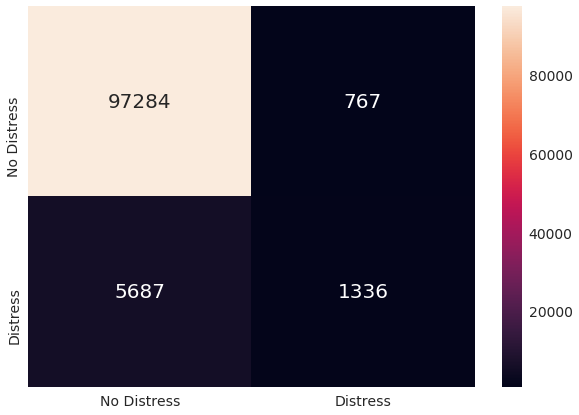

In [79]:
train_pred_pandas = predictionAndLabels_train_gbt.toPandas()
train_actuals = train_pred_pandas.label.tolist()
train_predictions = train_pred_pandas.prediction.tolist()


test_pred_pandas = predictionAndLabels_test_gbt.toPandas()
test_actuals = test_pred_pandas.label.tolist()
test_predictions = test_pred_pandas.prediction.tolist()
from sklearn import metrics as smetrics
cm = smetrics.confusion_matrix(train_actuals, train_predictions)

df_cm = pd.DataFrame(cm)
df_cm.index = ['No Distress', 'Distress']
df_cm.columns = ['No Distress', 'Distress']
names=['No Distress', 'Distress']
print(df_cm)
fig = plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"size": 20})#

### Lets use Stratified sampling approach

- We will use part of training data set with 1's boosted and few 0's
- Then we predict full training and validation data using this model
- Theoritically this should ensure higher recall

In [87]:
sample_data = trainingData1.sampleBy("Target", fractions={0: 0.12, 1: 0.9}, seed=12345)
print('Total records are: ', sample_data.count())
sample_data.show(4)

('Total records are: ', 18092)
+------+-----------+---+-------+-----------+--------------+-------+-------+-------+-------+------------------+
|Target|Utilization|age|FD_ind1| Debt_Ratio|Monthly_Income|FD_ind2|FD_ind3|FD_ind4|FD_ind5|NumberOfDependents|
+------+-----------+---+-------+-----------+--------------+-------+-------+-------+-------+------------------+
|     0|        0.0| 22|      0|        0.0|         780.0|      1|      0|      0|      0|                 0|
|     0|        0.0| 22|      0|        0.0|        1520.0|      1|      0|      0|      0|                 1|
|     0|        0.0| 22|      0|0.106642291|        1640.0|      3|      0|      0|      0|                 0|
|     0|        0.0| 23|      0|        0.0|        6166.0|      1|      0|      0|      0|                 0|
+------+-----------+---+-------+-----------+--------------+-------+-------+-------+-------+------------------+
only showing top 4 rows



In [88]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_Pipeline = Pipeline(stages=preprocessiong_Stages+[gbt]) 
gbt_Pipeline_model = gbt_Pipeline.fit(sample_data)
train_predictions_gbt = gbt_Pipeline_model.transform(trainingData1)
test_predictions_gbt = gbt_Pipeline_model.transform(valData1)

In [89]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_gbt = train_predictions_gbt.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_gbt)
print("Train set accuracy  = " + str(train_accuracy))
print("Train Error = %g" % (1.0 - train_accuracy))

predictionAndLabels_test_gbt = test_predictions_gbt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_gbt)
print("Test set accuracy = " + str(test_accuracy))
print("Test Error = %g" % (1.0 - test_accuracy))

Train set accuracy  = 0.881911795497
Train Error = 0.118088
Test set accuracy = 0.880937541735
Test Error = 0.119062


In [90]:
true_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 0) & (predictionAndLabels_train_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_gbt[(predictionAndLabels_train_gbt.label == 1) & (predictionAndLabels_train_gbt.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Train Recall: ", recall

true_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
true_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
false_positive = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 0) & (predictionAndLabels_test_gbt.prediction == 1.0)].count()
false_negative = predictionAndLabels_test_gbt[(predictionAndLabels_test_gbt.label == 1) & (predictionAndLabels_test_gbt.prediction == 0.0)].count()
recall = true_positive / float(true_positive + false_negative)
print "Val Recall: ", recall

Train Recall:  0.630642175708
Val Recall:  0.61371961372


### we can see that this is giving the highest recall when compared to other models and also there is little overfitting as the difference between train and val is low